In [1]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B
Saving models to: /kaggle/working/checkpoints


In [2]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [3]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS
###############################################
from pathlib import Path

# Correct TrainA paths
train_img_dir = f"{PREPROCESS_ROOT}/TrainB/images"
train_gt_dir  = f"{PREPROCESS_ROOT}/TrainB/gt"

# List .pt files
train_imgs = sorted([str(p) for p in Path(train_img_dir).glob("*.pt")])
train_gts  = sorted([str(p) for p in Path(train_gt_dir).glob("*.pt")])

# Verify counts
print("Total image files in TrainB:", len(train_imgs))
print("Total GT files in TrainB   :", len(train_gts))

# Sanity check
if len(train_imgs) != len(train_gts):
    print("WARNING: Image/GT count mismatch!")

# 10% validation split
num = len(train_imgs)
val_num = num // 10
print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]
val_imgs_split   = train_imgs[-val_num:]
val_gts_split    = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Read GT size for CSRNet wrapper
_, sample_gt = train_ds[0]
GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files in TrainB: 400
Total GT files in TrainB   : 400
Validation size: 40
Training samples: 360
Validation samples: 40
GT shape detected: 64 x 64


In [4]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# CSRNET MODEL 
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Wrapper to match GT size
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

model = CSRNetWrapper(CSRNet(), GT_H, GT_W).cuda()
print("Model loaded.")


Train batches: 45
Val batches: 5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s] 


Model loaded.


In [5]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 100
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 100 epochs...


In [6]:
###############################################
# 6) TRAINING LOOP (100 EPOCHS)
###############################################
for epoch in range(1, NUM_EPOCHS+1):

    # TRAIN
    model.train()
    train_loss = 0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)
        loss = criterion(preds, gts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, gts = imgs.cuda(), gts.cuda()
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

    # Save every 20 epochs
    if epoch % 20 == 0:
        ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, ckpt_path)
        print("Saved:", ckpt_path)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = f"{CHECKPOINT_DIR}/best_model.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, best_path)
        print("BEST model saved:", best_path)

# Save final model
final_path = f"{CHECKPOINT_DIR}/final_epoch100.pth"
torch.save({"epoch": 100, "model_state": model.state_dict()}, final_path)
print("FINAL model saved:", final_path)


Epoch 1 Val: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 1: Train=0.018266  Val=0.011335
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 2 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 2: Train=0.011705  Val=0.007671
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 3 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 3: Train=0.008768  Val=0.006731
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 4 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 4: Train=0.007607  Val=0.006278
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 5 Val: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch 5: Train=0.006937  Val=0.006043
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 6 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 6: Train=0.006426  Val=0.006155


Epoch 7 Val: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 7: Train=0.005992  Val=0.005778
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 8 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 8: Train=0.005842  Val=0.005550
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 9 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 9: Train=0.005498  Val=0.005405
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 10 Val: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch 10: Train=0.005090  Val=0.005448


Epoch 11 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 11: Train=0.004820  Val=0.005397
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 12 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 12: Train=0.004605  Val=0.005339
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 13 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 13: Train=0.004528  Val=0.005397


Epoch 14 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 14: Train=0.004413  Val=0.005513


Epoch 15 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 15: Train=0.004519  Val=0.005229
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 16 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 16: Train=0.004080  Val=0.005110
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 17 Val: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 17: Train=0.003980  Val=0.005195


Epoch 18 Val: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 18: Train=0.003852  Val=0.005070
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 19 Val: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch 19: Train=0.003605  Val=0.005074


Epoch 20 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 20: Train=0.003910  Val=0.005016
Saved: /kaggle/working/checkpoints/checkpoint_epoch20.pth
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 21 Val: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch 21: Train=0.003449  Val=0.004968
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 22 Val: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch 22: Train=0.003341  Val=0.004995


Epoch 23 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 23: Train=0.003192  Val=0.004998


Epoch 24 Val: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Epoch 24: Train=0.003150  Val=0.005012


Epoch 25 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 25: Train=0.003064  Val=0.005057


Epoch 26 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 26: Train=0.002969  Val=0.005025


Epoch 27 Val: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 27: Train=0.003354  Val=0.004940
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 28 Val: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 28: Train=0.003022  Val=0.005094


Epoch 29 Val: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch 29: Train=0.002737  Val=0.005115


Epoch 30 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 30: Train=0.002685  Val=0.005104


Epoch 31 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 31: Train=0.002607  Val=0.005122


Epoch 32 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 32: Train=0.002710  Val=0.005221


Epoch 33 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 33: Train=0.002491  Val=0.005090


Epoch 34 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 34: Train=0.002424  Val=0.004964


Epoch 35 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 35: Train=0.002299  Val=0.004988


Epoch 36 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 36: Train=0.002208  Val=0.004996


Epoch 37 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 37: Train=0.002157  Val=0.005126


Epoch 38 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 38: Train=0.002131  Val=0.005394


Epoch 39 Val: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Epoch 39: Train=0.002324  Val=0.005102


Epoch 40 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 40: Train=0.002150  Val=0.005086
Saved: /kaggle/working/checkpoints/checkpoint_epoch40.pth


Epoch 41 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 41: Train=0.002009  Val=0.005010


Epoch 42 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 42: Train=0.001878  Val=0.004947


Epoch 43 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 43: Train=0.001829  Val=0.004978


Epoch 44 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 44: Train=0.001758  Val=0.005025


Epoch 45 Val: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Epoch 45: Train=0.001763  Val=0.005103


Epoch 46 Val: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Epoch 46: Train=0.001746  Val=0.005044


Epoch 47 Val: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch 47: Train=0.001705  Val=0.005141


Epoch 48 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 48: Train=0.001653  Val=0.004999


Epoch 49 Val: 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 49: Train=0.001598  Val=0.005043


Epoch 50 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 50: Train=0.001549  Val=0.005161


Epoch 51 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 51: Train=0.001503  Val=0.005047


Epoch 52 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 52: Train=0.001493  Val=0.005169


Epoch 53 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 53: Train=0.001499  Val=0.005373


Epoch 54 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 54: Train=0.001634  Val=0.005010


Epoch 55 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 55: Train=0.001533  Val=0.005585


Epoch 56 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 56: Train=0.001729  Val=0.005161


Epoch 57 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 57: Train=0.001340  Val=0.005083


Epoch 58 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 58: Train=0.001364  Val=0.005053


Epoch 59 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 59: Train=0.001280  Val=0.005161


Epoch 60 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 60: Train=0.001218  Val=0.005139
Saved: /kaggle/working/checkpoints/checkpoint_epoch60.pth


Epoch 61 Val: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch 61: Train=0.001212  Val=0.005105


Epoch 62 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 62: Train=0.001116  Val=0.005258


Epoch 63 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 63: Train=0.001258  Val=0.005085


Epoch 64 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 64: Train=0.001242  Val=0.005219


Epoch 65 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 65: Train=0.001801  Val=0.005222


Epoch 66 Val: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 66: Train=0.001086  Val=0.005125


Epoch 67 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 67: Train=0.001007  Val=0.005144


Epoch 68 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 68: Train=0.000990  Val=0.005164


Epoch 69 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 69: Train=0.000943  Val=0.005155


Epoch 70 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 70: Train=0.000918  Val=0.005179


Epoch 71 Val: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch 71: Train=0.000884  Val=0.005200


Epoch 72 Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 72: Train=0.000848  Val=0.005167


Epoch 73 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 73: Train=0.000820  Val=0.005191


Epoch 74 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 74: Train=0.000811  Val=0.005168


Epoch 75 Val: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Epoch 75: Train=0.000780  Val=0.005196


Epoch 76 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 76: Train=0.000779  Val=0.005199


Epoch 77 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 77: Train=0.000785  Val=0.005226


Epoch 78 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 78: Train=0.000750  Val=0.005183


Epoch 79 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 79: Train=0.000747  Val=0.005298


Epoch 80 Val: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 80: Train=0.000693  Val=0.005268
Saved: /kaggle/working/checkpoints/checkpoint_epoch80.pth


Epoch 81 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 81: Train=0.000670  Val=0.005290


Epoch 82 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 82: Train=0.000694  Val=0.005239


Epoch 83 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 83: Train=0.000674  Val=0.005253


Epoch 84 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 84: Train=0.000625  Val=0.005271


Epoch 85 Val: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 85: Train=0.000604  Val=0.005290


Epoch 86 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 86: Train=0.000578  Val=0.005280


Epoch 87 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 87: Train=0.000560  Val=0.005282


Epoch 88 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 88: Train=0.000549  Val=0.005307


Epoch 89 Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Epoch 89: Train=0.000575  Val=0.005291


Epoch 90 Val: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 90: Train=0.000542  Val=0.005255


Epoch 91 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 91: Train=0.000531  Val=0.005402


Epoch 92 Val: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 92: Train=0.000553  Val=0.005307


Epoch 93 Val: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


Epoch 93: Train=0.000508  Val=0.005348


Epoch 94 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 94: Train=0.000541  Val=0.005481


Epoch 95 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 95: Train=0.000753  Val=0.005286


Epoch 96 Val: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 96: Train=0.000638  Val=0.005349


Epoch 97 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 97: Train=0.000489  Val=0.005370


Epoch 98 Val: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Epoch 98: Train=0.000467  Val=0.005324


Epoch 99 Val: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 99: Train=0.000455  Val=0.005306


Epoch 100 Val: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 100: Train=0.000497  Val=0.005315
Saved: /kaggle/working/checkpoints/checkpoint_epoch100.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch100.pth


In [7]:
###############################################
# 7) TESTING
###############################################
test_img_dir = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/images"
test_gt_dir  = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/gt"

test_imgs = sorted([str(p) for p in Path(test_img_dir).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(test_gt_dir).glob("*.pt")])

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

model.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_loader, desc="Testing"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)

        # pixel errors
        mae = torch.abs(preds-gts).mean(dim=[1,2,3]).cpu().numpy()
        mse = ((preds-gts)**2).mean(dim=[1,2,3]).cpu().numpy()
        pix_mae_list.extend(mae)
        pix_mse_list.extend(mse)

        # count errors
        pc = preds.sum(dim=[1,2,3]).cpu().numpy()
        gc = gts.sum(dim=[1,2,3]).cpu().numpy()

        for p, g in zip(pc, gc):
            abs_errs.append(abs(p-g))
            sq_errs.append((p-g)**2)

            if g > 0:
                acc = max(0, 1 - abs(p-g)/g)
            else:
                acc = 1 if p < 1e-6 else 0

            acc_list.append(acc)

print("\n=== TEST RESULTS ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list))*100, "%")


Testing: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


=== TEST RESULTS ===
Pixel MAE: 0.025487413629889488
Pixel RMSE: 0.07360959053039551
Count MAE: 13.46163272857666
Count RMSE: 19.308248753286968
Counting Accuracy: 86.34963217300998 %


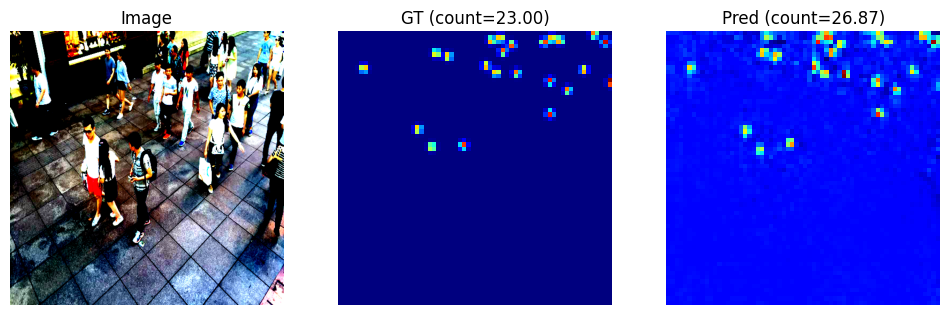

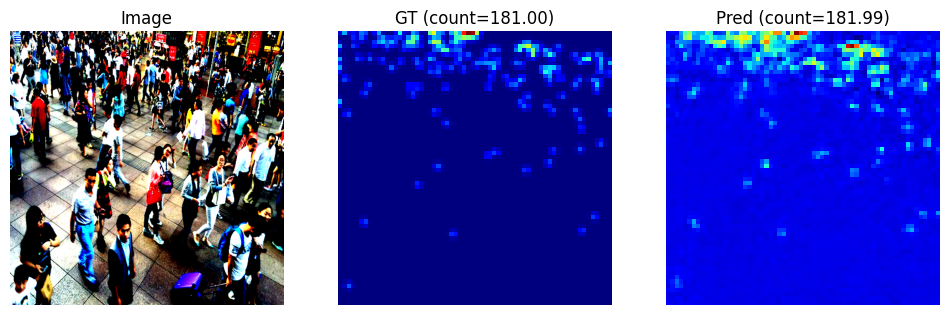

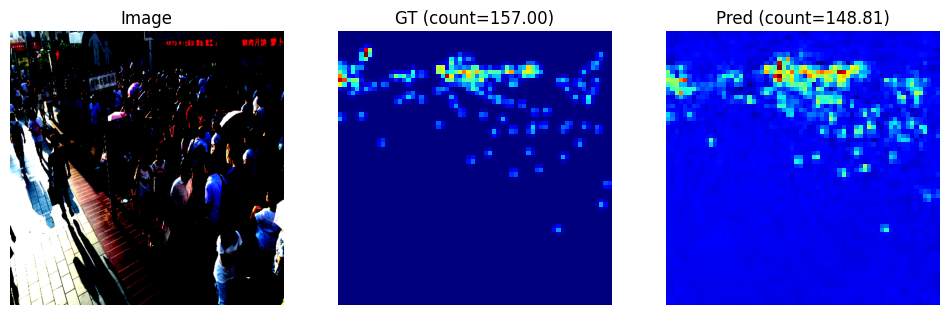

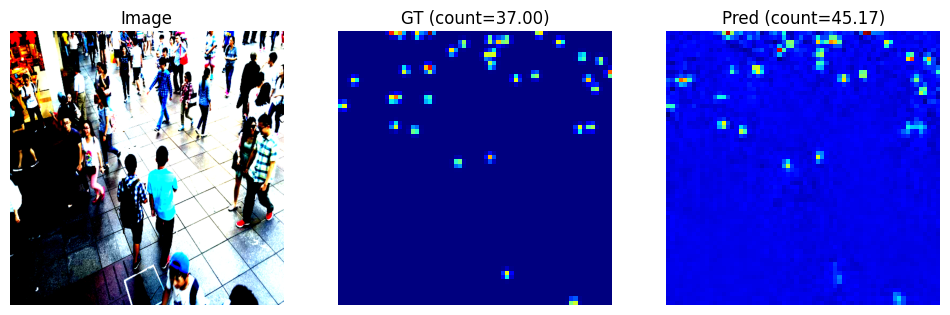

In [8]:
###############################################
# 8) VISUALIZE 4 SAMPLES
###############################################

def show_map(img, gt, pred):
    # Convert image tensor to numpy
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # Convert GT & prediction to numpy
    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    # GT density
    plt.subplot(1,3,2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    # Predicted density
    plt.subplot(1,3,3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


# ---- RUN VISUALIZATION FOR 4 SAMPLES ----
for i in range(4):
    img, gt = test_ds[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda())[0].cpu()
    show_map(img, gt, pred)
